Step 1: Loading data & aligning
Step 2: Tuning Models...
   -> Tuning Random Forest
   -> Tuning Gradient Boosting
Step 3: Creating Voting Ensemble
Step 4: Finding Optimal Threshold
   -> Best Threshold: 0.55
Step 5: Running Detailed Backtest

              FINAL PERFORMANCE REPORT (RF + HGB)
             Metric  Before Costs  After Costs
0      Total Return      0.902449     0.513012
1     CAGR (Annual)      0.237403     0.147006
2  Volatility (Ann)      0.179989     0.179416
3      Sharpe Ratio      1.274485     0.853966
4      Max Drawdown     -0.113915    -0.129956
------------------------------------------------------------
Total Trades: 115
Win Rate: 54.78%


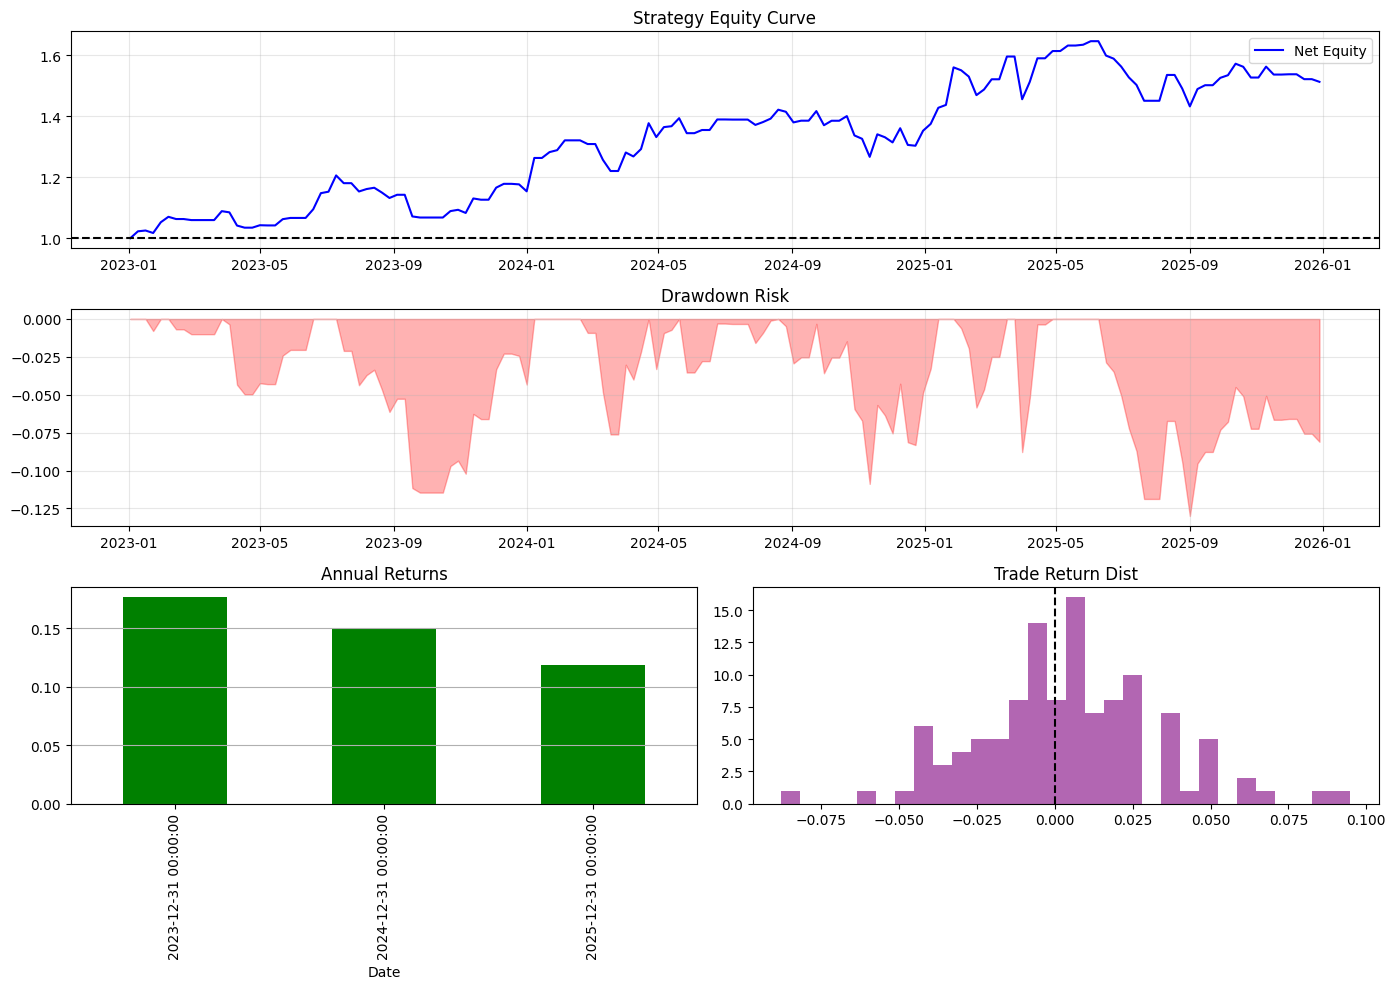

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform


stocks = [
    "BAJFINANCE", "BHARTIARTL", "HCLTECH", "HDFCBANK",
    "HINDUNILVR", "ICICIBANK", "INFY", "MARUTI",
    "RELIANCE", "TCS"
]

transaction_cost = 0.001
features = ['Returns_1W', 'Returns_4W', 'RSI', 'MACD']
combined_df = pd.DataFrame()

print("Step 1: Loading data & aligning")

for stock in stocks:
    file_path = f"{stock}.csv"
    if not os.path.exists(file_path):
        continue

    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)

    # Calculating indicators
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(com=13, adjust=False).mean()
    avg_loss = loss.ewm(com=13, adjust=False).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26

    # Resampling to weekly bars reduces daily noise.
    df_weekly = df.resample('W-MON').last()
    df_weekly['Returns_1W'] = df_weekly['Close'].pct_change(1)
    df_weekly['Returns_4W'] = df_weekly['Close'].pct_change(4)

    # Target: 1 if next week's close is higher, else 0.
    df_weekly['Next_Close'] = df_weekly['Close'].shift(-1)
    df_weekly['Next_Week_Return'] = (df_weekly['Next_Close'] / df_weekly['Close']) - 1
    df_weekly['Target'] = (df_weekly['Next_Week_Return'] > 0).astype(int)
    df_weekly['Ticker'] = stock

    df_weekly = df_weekly.iloc[26:]
    df_weekly.dropna(inplace=True)
    combined_df = pd.concat([combined_df, df_weekly])

# Sorting by date  to prevent look-ahead bias during splitting.
combined_df.sort_index(inplace=True)


CUTOFF_DATE = pd.Timestamp("2023-01-01")
train_data = combined_df[combined_df.index < CUTOFF_DATE].copy().dropna()
test_data = combined_df[combined_df.index >= CUTOFF_DATE].copy().dropna()

X_train = train_data[features]
y_train = train_data['Target']

print("Step 2: Tuning Models...")

# Since 10 rows = 1 full week of market data, and our target looks 1 week ahead,
# a gap of 10 ensures the model never peeks at future data during validation.
tscv = TimeSeriesSplit(n_splits=3, gap=10)

print("   -> Tuning Random Forest")

rf_base = RandomForestClassifier(random_state=42)
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_samples_leaf': randint(20, 100),
    'max_features': ['sqrt', 'log2']
}
rf_search = RandomizedSearchCV(rf_base, param_dist_rf, n_iter=15, cv=tscv, scoring='roc_auc', n_jobs=-1,
                               random_state=42)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

print("   -> Tuning Gradient Boosting")

hgb_base = HistGradientBoostingClassifier(random_state=42, early_stopping=True)
param_dist_hgb = {
    'learning_rate': uniform(0.01, 0.2),
    'max_iter': randint(50, 200),
    'max_depth': randint(3, 10),
    'l2_regularization': uniform(0, 10)
}
hgb_search = RandomizedSearchCV(hgb_base, param_dist_hgb, n_iter=15, cv=tscv, scoring='roc_auc', n_jobs=-1,
                                random_state=42)
hgb_search.fit(X_train, y_train)
best_hgb = hgb_search.best_estimator_

print("Step 3: Creating Voting Ensemble")
# Voting balances the variance of the two models.
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('hgb', best_hgb)],
    voting='soft',
    weights=[1, 1]
)
voting_clf.fit(X_train, y_train)

print("Step 4: Finding Optimal Threshold")
best_threshold = 0.50
best_return = -100.0
train_probs = voting_clf.predict_proba(X_train)[:, 1]
train_data['Probability'] = train_probs

# We scan thresholds to find which maximizes returns on training data.
for thresh in np.arange(0.50, 0.65, 0.01):
    cumulative_log_return = 0.0
    for date in train_data.index.unique().sort_values():
        weekly = train_data[train_data.index == date]
        if len(weekly) < 2: continue

        top = weekly.sort_values(by='Probability', ascending=False).head(2)
        valid = top[top['Probability'] > thresh]

        if len(valid) > 0:
            r = valid['Next_Week_Return'].mean()
            cumulative_log_return += np.log1p(r - (transaction_cost * 2))

    ret = np.exp(cumulative_log_return) - 1
    if ret > best_return:
        best_return = ret
        best_threshold = thresh

CONFIDENCE_THRESHOLD = best_threshold
print(f"   -> Best Threshold: {CONFIDENCE_THRESHOLD:.2f}")

print("Step 5: Running Detailed Backtest")
portfolio_history = []

# We run the backtest on unseen test data, taking trades only if confidence is high.
for date in test_data.index.unique().sort_values():
    weekly = test_data[test_data.index == date].copy()
    if len(weekly) < 2: continue

    preds = voting_clf.predict_proba(weekly[features])[:, 1]
    weekly['Probability'] = preds

    top = weekly.sort_values(by='Probability', ascending=False).head(2)
    trade_candidates = top[top['Probability'] > CONFIDENCE_THRESHOLD]

    if not trade_candidates.empty:
        raw_return = trade_candidates['Next_Week_Return'].mean()
        cost = (transaction_cost * 2)
        gross_return = raw_return
        net_return = raw_return - cost
        action = "Trade"
        turnover = 1.0
    else:
        gross_return = 0.0
        net_return = 0.0
        action = "Cash"
        turnover = 0.0

    portfolio_history.append({
        'Date': date, 'Gross_Return': gross_return,
        'Net_Return': net_return, 'Action': action, 'Turnover': turnover
    })

if portfolio_history:
    results = pd.DataFrame(portfolio_history)
    results.set_index('Date', inplace=True)

    results['Cum_Gross'] = (1 + results['Gross_Return']).cumprod()
    results['Cum_Net'] = (1 + results['Net_Return']).cumprod()

    running_max = results['Cum_Net'].cummax()
    results['Drawdown'] = (results['Cum_Net'] / running_max) - 1
    annual_returns = results['Net_Return'].resample('YE').apply(lambda x: (1 + x).prod() - 1)

    def get_cagr(series):
        if len(series) == 0: return 0
        return ((1 + series).cumprod().iloc[-1]) ** (52 / len(series)) - 1

    def get_max_dd(series):
        cum = (1 + series).cumprod()
        peak = cum.expanding().max()
        return ((cum / peak) - 1).min()

    def get_sharpe(series):
        if series.std() == 0: return 0
        return (series.mean() * 52) / (series.std() * np.sqrt(52))

    metrics_data = {
        'Metric': ['Total Return', 'CAGR (Annual)', 'Volatility (Ann)', 'Sharpe Ratio', 'Max Drawdown'],
        'Before Costs': [
            (results['Cum_Gross'].iloc[-1] - 1), get_cagr(results['Gross_Return']),
            results['Gross_Return'].std() * np.sqrt(52), get_sharpe(results['Gross_Return']),
            get_max_dd(results['Gross_Return'])
        ],
        'After Costs': [
            (results['Cum_Net'].iloc[-1] - 1), get_cagr(results['Net_Return']),
            results['Net_Return'].std() * np.sqrt(52), get_sharpe(results['Net_Return']),
            get_max_dd(results['Net_Return'])
        ]
    }

    metrics_df = pd.DataFrame(metrics_data)
    print("\n" + "=" * 60)
    print("              FINAL PERFORMANCE REPORT (RF + HGB)")
    print("=" * 60)
    print(metrics_df)
    print("-" * 60)

    trades = results[results['Action'] == 'Trade']
    if len(trades) > 0:
        win_rate = len(trades[trades['Net_Return'] > 0]) / len(trades)
        print(f"Total Trades: {len(trades)}")
        print(f"Win Rate: {win_rate:.2%}")
    else:
        print("No trades executed.")
    print("=" * 60)

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2)

    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(results.index, results['Cum_Net'], label='Net Equity', color='blue')
    ax1.axhline(y=1, color='black', linestyle='--')
    ax1.set_title('Strategy Equity Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(gs[1, :])
    ax2.fill_between(results.index, results['Drawdown'], 0, color='red', alpha=0.3)
    ax2.set_title('Drawdown Risk')
    ax2.grid(True, alpha=0.3)

    ax3 = fig.add_subplot(gs[2, 0])
    if len(annual_returns) > 0:
        annual_returns.plot(kind='bar', ax=ax3, color=['g' if x > 0 else 'r' for x in annual_returns])
    ax3.set_title('Annual Returns')
    ax3.grid(axis='y')

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.hist(trades['Net_Return'], bins=30, color='purple', alpha=0.6)
    ax4.set_title('Trade Return Dist')
    ax4.axvline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()